In [1]:
import pandas as pd
df = pd.read_csv("Downloads/ott_platform_dataset.csv")
df.head()


,event_id,user_id,user_age,user_gender,user_region,subscription_type,signup_date,last_active,device,session_id,...,churn_label,social_shares,watch_start_time,audio_languages,subtitles,bitrate_kbps,network,resolution,mood_tag,metadata_text
0,ev_00001,user_0398,26,Female,DL,Standard,2021-05-12,2024-09-12,GameConsole,sess_13478,...,0,0,2024-09-08 03:09:00,"English,Tamil",No,3000,WiFi,480p,Educational,Title 58 S1 | Thriller | Director_95 | French
1,ev_00002,user_0158,53,Other,WB,Free,2021-05-29,2024-02-23,Web,sess_46434,...,0,4,2024-01-25 07:29:00,"Korean,English",Yes,800,WiFi,4K,Suspense,Title 275 S1 | Comedy | Director_85 | French
2,ev_00003,user_0360,13,Other,AP,Premium,2018-02-04,2024-07-05,Mobile,sess_74686,...,0,5,2024-06-05 03:54:00,"Korean,French",No,800,WiFi,4K,Dark,Title 109 S5 | Thriller | Director_32 | Hindi
3,ev_00004,user_0308,44,Male,WB,Basic,2022-06-10,2025-08-25,Mobile,sess_79514,...,0,4,2025-08-02 04:17:00,French,No,3000,5G,1080p,Thrilling,Title 2 S3 | Horror | Director_78 | Korean
4,ev_00005,user_0184,49,Other,DL,Free,2017-09-04,2023-04-11,Mobile,sess_92719,...,0,3,2023-03-14 08:17:00,"Korean,Telugu",Yes,800,4G,4K,Suspense,Title 217 S2 | Romance | Director_32 | Spanish


In [3]:
# cell 0: imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp

plt.rcParams['figure.figsize'] = (8,5)

# load dataset (adjust path if needed)
df = pd.read_csv("Downloads/ott_platform_dataset.csv", parse_dates=['signup_date','last_active'], low_memory=False)
df.head()


,event_id,user_id,user_age,user_gender,user_region,subscription_type,signup_date,last_active,device,session_id,...,churn_label,social_shares,watch_start_time,audio_languages,subtitles,bitrate_kbps,network,resolution,mood_tag,metadata_text
0,ev_00001,user_0398,26,Female,DL,Standard,12-05-2021,12-09-2024,GameConsole,sess_13478,...,0,0,08-09-2024 03:09,"English,Tamil",No,3000,WiFi,480p,Educational,Title 58 S1 | Thriller | Director_95 | French
1,ev_00002,user_0158,53,Other,WB,Free,29-05-2021,23-02-2024,Web,sess_46434,...,0,4,25-01-2024 07:29,"Korean,English",Yes,800,WiFi,4K,Suspense,Title 275 S1 | Comedy | Director_85 | French
2,ev_00003,user_0360,13,Other,AP,Premium,04-02-2018,05-07-2024,Mobile,sess_74686,...,0,5,05-06-2024 03:54,"Korean,French",No,800,WiFi,4K,Dark,Title 109 S5 | Thriller | Director_32 | Hindi
3,ev_00004,user_0308,44,Male,WB,Basic,10-06-2022,25-08-2025,Mobile,sess_79514,...,0,4,02-08-2025 04:17,French,No,3000,5G,1080p,Thrilling,Title 2 S3 | Horror | Director_78 | Korean
4,ev_00005,user_0184,49,Other,DL,Free,04-09-2017,11-04-2023,Mobile,sess_92719,...,0,3,14-03-2023 08:17,"Korean,Telugu",Yes,800,4G,4K,Suspense,Title 217 S2 | Romance | Director_32 | Spanish


In [5]:
# 1. Basic EDA (quick visual checks)

Rows, columns: (1000, 46)

Columns: ['event_id', 'user_id', 'user_age', 'user_gender', 'user_region', 'subscription_type', 'signup_date', 'last_active', 'device', 'session_id', 'content_id', 'title', 'content_type', 'primary_genre', 'genres', 'language', 'release_year', 'duration_min', 'director', 'main_cast', 'description', 'avg_rating', 'user_rating', 'watch_time_min', 'watch_percentage', 'completed', 'watch_date', 'play_count', 'is_original', 'popularity_rank', 'imdb_score', 'maturity_rating', 'tags_count', 'num_seasons', 'episodes', 'recommendation_source', 'churn_label', 'social_shares', 'watch_start_time', 'audio_languages', 'subtitles', 'bitrate_kbps', 'network', 'resolution', 'mood_tag', 'metadata_text']


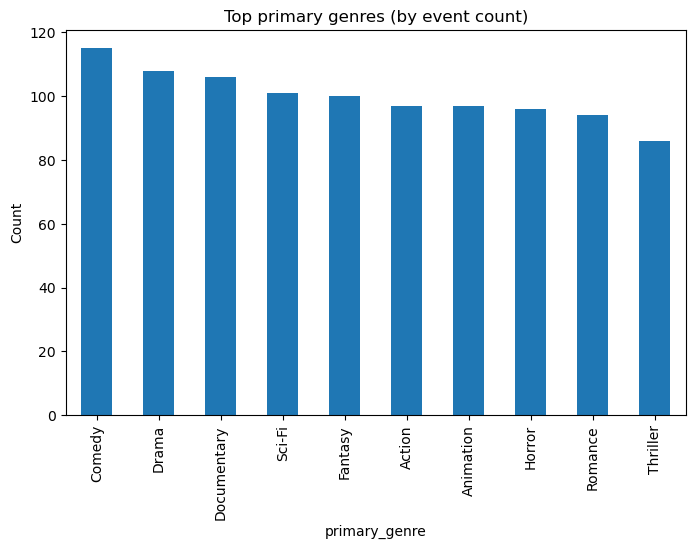

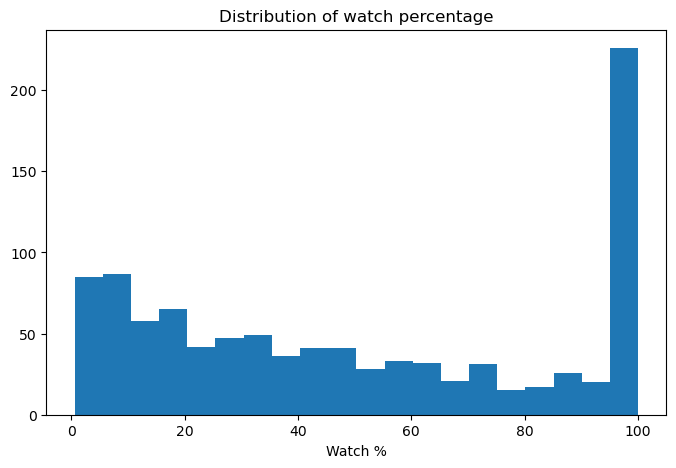

       content_id         title  play_count
521  content_0154  Title 143 S2          13
678  content_0204  Title 179 S2           8
666  content_0199   Title 88 S2           8
484  content_0145  Title 168 S5           8
241  content_0072  Title 156 S1           8
482  content_0144   Title 83 S4           8
898  content_0273  Title 170 S2           8
673  content_0202  Title 158 S2           8
238  content_0069   Title 34 S3           8
107  content_0026   Title 12 S3           8


In [7]:
# cell 1: basic stats & simple visualizations
print("Rows, columns:", df.shape)
print("\nColumns:", list(df.columns))

# Top genres count
top_genres = df['primary_genre'].value_counts().head(10)
top_genres.plot(kind='bar')
plt.title("Top primary genres (by event count)")
plt.ylabel("Count")
plt.show()

# Watch percentage distribution
plt.hist(df['watch_percentage'].dropna(), bins=20)
plt.title("Distribution of watch percentage")
plt.xlabel("Watch %")
plt.show()

# Popular content (top 10)
top_content = df.groupby(['content_id','title'])['play_count'].sum().reset_index().sort_values('play_count', ascending=False).head(10)
print(top_content)

#Explanation: checks genre mix, watch completion rates, and top content by play count.


In [9]:
# 2. Use Case 1 — Collaborative Filtering (SVD-based latent factors)

In [11]:
# cell 2.1: prepare user-item matrix
df_cf = df.copy()

# create an interaction score: prefer explicit rating if present, else scaled watch_percentage (0-10)
def interaction_score(row):
    if not np.isnan(row['user_rating']):
        return row['user_rating']
    else:
        # scale watch_percentage to 0-10
        return (row['watch_percentage']/100.0) * 10.0

df_cf['interaction'] = df_cf.apply(interaction_score, axis=1)

# pivot to user-item (we'll aggregate by mean if multiple events)
ratings = df_cf.groupby(['user_id','content_id'])['interaction'].mean().reset_index()
user_encoder = LabelEncoder().fit(ratings['user_id'])
item_encoder = LabelEncoder().fit(ratings['content_id'])
ratings['user_idx'] = user_encoder.transform(ratings['user_id'])
ratings['item_idx'] = item_encoder.transform(ratings['content_id'])

n_users = ratings['user_idx'].nunique()
n_items = ratings['item_idx'].nunique()

# build sparse matrix
rows_idx = ratings['user_idx'].values
cols_idx = ratings['item_idx'].values
data_vals = ratings['interaction'].values
R = sp.csr_matrix((data_vals, (rows_idx, cols_idx)), shape=(n_users, n_items))

print("user-item matrix shape:", R.shape)

# cell 2.2: truncated SVD for latent factors
k = 50  # latent dims (tune)
svd = TruncatedSVD(n_components=min(k, min(R.shape)-1), random_state=42)
U = svd.fit_transform(R)          # users x k
Sigma = svd.singular_values_     # k
VT = svd.components_             # k x items

# approximate predicted rating matrix (dense for demo; use sparse in production)
preds = np.dot(U, VT)  # users x items

# helper: recommend function
def recommend_for_user(user_id, top_n=10):
    if user_id not in user_encoder.classes_:
        return []  # cold-start
    uidx = user_encoder.transform([user_id])[0]
    user_scores = preds[uidx]
    known_items = ratings[ratings['user_idx']==uidx]['item_idx'].tolist()
    # mask known items
    user_scores_masked = user_scores.copy()
    user_scores_masked[known_items] = -np.inf
    top_idxs = np.argsort(user_scores_masked)[-top_n:][::-1]
    items = item_encoder.inverse_transform(top_idxs)
    return items

# demo for a random user
sample_user = ratings['user_id'].sample(1).iloc[0]
print("Recommendations (CF-SVD) for", sample_user)
print(recommend_for_user(sample_user, top_n=5))


user-item matrix shape: (310, 289)
Recommendations (CF-SVD) for user_0239
['content_0011' 'content_0199' 'content_0065' 'content_0273'
 'content_0291']


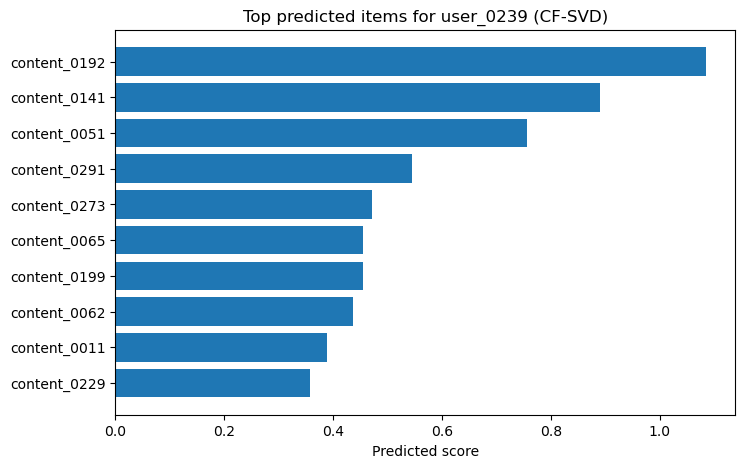

In [13]:
# visualize predicted scores for sample user
uidx = user_encoder.transform([sample_user])[0]
user_scores = preds[uidx]
top_idxs = np.argsort(user_scores)[-10:][::-1]
top_scores = user_scores[top_idxs]
top_titles = item_encoder.inverse_transform(top_idxs)

plt.barh(range(len(top_titles))[::-1], top_scores)
plt.yticks(range(len(top_titles)), top_titles)
plt.title(f"Top predicted items for {sample_user} (CF-SVD)")
plt.xlabel("Predicted score")
plt.show()


In [15]:
# Use Case 2 — Content-Based Recommendations with TF-IDF

In [17]:
# cell 3.1: build metadata text
df_content = df[['content_id','title','description','genres','director','main_cast','metadata_text','primary_genre']].drop_duplicates('content_id').set_index('content_id')
df_content['meta_combined'] = df_content[['title','description','genres','director','main_cast','primary_genre']].astype(str).agg(' '.join, axis=1)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_content['meta_combined'])

# cosine similarity (item-item)
item_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# map content_id to index
content_idx_map = {cid: i for i,cid in enumerate(df_content.index)}

# recommend similar items to a given content_id
def content_similar(content_id, top_n=8):
    if content_id not in content_idx_map:
        return []
    idx = content_idx_map[content_id]
    sim_scores = item_sim[idx]
    sim_scores[idx] = -1
    top_idx = np.argsort(sim_scores)[-top_n:][::-1]
    return df_content.index[top_idx].tolist()

# demo
seed = df_content.index[0]
print("Seed content:", seed, df_content.loc[seed,'title'])
print("Content-based similar recommendations:", content_similar(seed, top_n=6))


Seed content: content_0273 Title 58 S1
Content-based similar recommendations: ['content_0227', 'content_0297', 'content_0256', 'content_0292', 'content_0130', 'content_0221']


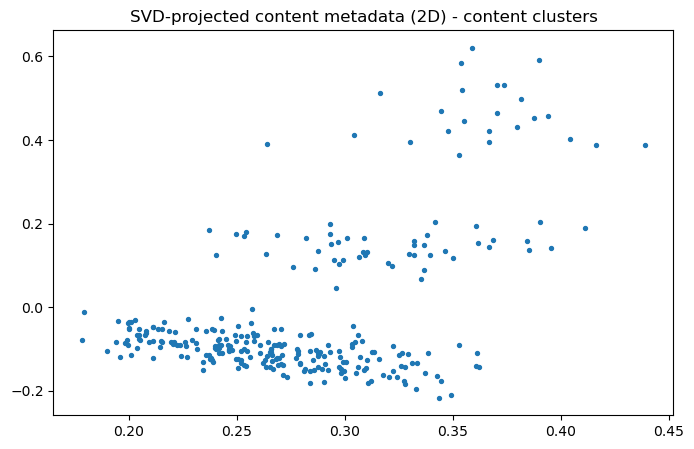

In [19]:
from sklearn.decomposition import TruncatedSVD as SVD_tf
svd2 = SVD_tf(n_components=2, random_state=42)
coords = svd2.fit_transform(tfidf_matrix)
plt.scatter(coords[:,0], coords[:,1], s=8)
plt.title("SVD-projected content metadata (2D) - content clusters")
plt.show()


In [21]:
# Use Case 3 — Hybrid Recommender (Weighted ensemble)

In [23]:
# cell 4.1: Prepare CF predictions matrix (from earlier) and item content similarity score for a user
# We'll compute a user-specific content score by averaging TF-IDF vectors of items the user liked.

# build item_id list aligned with item_encoder
item_list = item_encoder.classes_.tolist()

# map item index to content_id that's present in df_content (may differ); we'll create a mapping as best-effort
# For items missing in content metadata, we use zeros.
meta_index_of_item = []
for it in item_list:
    meta_index_of_item.append(content_idx_map.get(it, -1))

# Precompute item TF-IDF vectors aligned to item_list (rows match item_list)
import numpy as np
item_tfidf_matrix = np.zeros((len(item_list), tfidf_matrix.shape[1]))
for i, midx in enumerate(meta_index_of_item):
    if midx != -1:
        item_tfidf_matrix[i] = tfidf_matrix[midx].toarray()

# helper to get content-based score for user (cosine similarity between user's liked items and all items)
from sklearn.preprocessing import normalize
item_tfidf_norm = normalize(item_tfidf_matrix)

def user_content_score(user_id):
    if user_id not in user_encoder.classes_:
        return np.zeros(len(item_list))
    uidx = user_encoder.transform([user_id])[0]
    user_items_idx = ratings[ratings['user_idx']==uidx]['item_idx'].tolist()
    if len(user_items_idx)==0:
        return np.zeros(len(item_list))
    # average TF-IDF vector of user's items
    user_vecs = item_tfidf_norm[user_items_idx]
    mean_vec = user_vecs.mean(axis=0)
    scores = item_tfidf_norm.dot(mean_vec)
    return scores

# popularity score: use inverse rank -> higher for low rank number (popular)
pop_map = {}
pop_df = df[['content_id','popularity_rank']].drop_duplicates('content_id')
pop_map = dict(zip(pop_df['content_id'], pop_df['popularity_rank']))
pop_scores = np.array([1.0/(1 + pop_map.get(it, 2000)) for it in item_list])

# combine for a sample user
sample_user = ratings['user_id'].sample(1).iloc[0]
cf_scores = preds[user_encoder.transform([sample_user])[0]]
# align cf_scores length to item_list (it is already aligned)
cf_norm = (cf_scores - np.nanmin(cf_scores)) / (np.nanmax(cf_scores)-np.nanmin(cf_scores)+1e-9)
content_scores = user_content_score(sample_user)
content_norm = (content_scores - content_scores.min())/(content_scores.max()-content_scores.min()+1e-9)
pop_norm = (pop_scores - pop_scores.min())/(pop_scores.max()-pop_scores.min()+1e-9)

alpha, beta, gamma = 0.6, 0.3, 0.1
combined = alpha*cf_norm + beta*content_norm + gamma*pop_norm

# mask known items
known = ratings[ratings['user_idx']==user_encoder.transform([sample_user])[0]]['item_idx'].tolist()
combined_masked = combined.copy()
combined_masked[known] = -np.inf
top_idx = np.argsort(combined_masked)[-10:][::-1]
recommended_items = [item_list[i] for i in top_idx]
print("Hybrid recommendations for", sample_user, ":\n", recommended_items)


Hybrid recommendations for user_0285 :
 ['content_0128', 'content_0136', 'content_0145', 'content_0289', 'content_0291', 'content_0208', 'content_0201', 'content_0293', 'content_0022', 'content_0188']


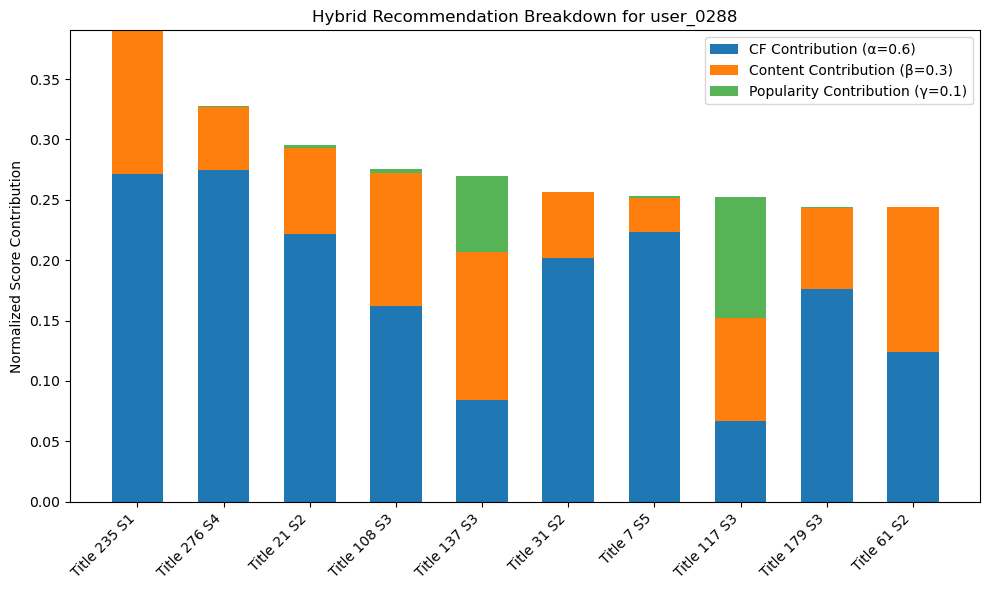

Top Hybrid Recommendations for user: user_0288


,content_id,cf_score,content_score,popularity_score,hybrid_score
title,,,,,
Title 235 S1,content_0131,0.452,0.397,0.000,0.391
Title 276 S4,content_0062,0.458,0.174,0.005,0.327
Title 21 S2,content_0049,0.369,0.237,0.030,0.295
Title 108 S3,content_0147,0.270,0.366,0.037,0.275
Title 137 S3,content_0298,0.140,0.408,0.635,0.270
Title 31 S2,content_0178,0.336,0.183,0.000,0.257
Title 7 S5,content_0182,0.372,0.093,0.021,0.253
Title 117 S3,content_0009,0.112,0.283,1.000,0.252
Title 179 S3,content_0140,0.293,0.225,0.003,0.244


In [25]:
# --- Hybrid Recommendation Visualization (Case 3) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assume you already have these from earlier cells:
# df, preds (CF scores), user_encoder, item_encoder, tfidf_matrix, item_tfidf_matrix, df_content, content_idx_map

# Step 1: recompute hybrid scores for a given user
sample_user = ratings['user_id'].sample(1).iloc[0]
uidx = user_encoder.transform([sample_user])[0]

# Collaborative filtering predicted scores
cf_scores = preds[uidx]
cf_norm = (cf_scores - np.nanmin(cf_scores)) / (np.nanmax(cf_scores) - np.nanmin(cf_scores) + 1e-9)

# Content-based similarity scores (average TF-IDF vector of user's liked items)
from sklearn.preprocessing import normalize
item_tfidf_norm = normalize(item_tfidf_matrix)

def user_content_score(user_id):
    uidx = user_encoder.transform([user_id])[0]
    user_items_idx = ratings[ratings['user_idx']==uidx]['item_idx'].tolist()
    if not user_items_idx:
        return np.zeros(len(item_tfidf_matrix))
    user_vecs = item_tfidf_norm[user_items_idx]
    mean_vec = user_vecs.mean(axis=0)
    scores = item_tfidf_norm.dot(mean_vec)
    return scores

content_scores = user_content_score(sample_user)
content_norm = (content_scores - content_scores.min())/(content_scores.max()-content_scores.min()+1e-9)

# Popularity score (inverse rank)
pop_map = dict(zip(df['content_id'], df['popularity_rank']))
item_list = item_encoder.classes_
pop_scores = np.array([1.0/(1 + pop_map.get(it, 2000)) for it in item_list])
pop_norm = (pop_scores - pop_scores.min())/(pop_scores.max()-pop_scores.min()+1e-9)

# Combine with weights
alpha, beta, gamma = 0.6, 0.3, 0.1
combined = alpha*cf_norm + beta*content_norm + gamma*pop_norm

# Mask items user already watched
known_items = ratings[ratings['user_idx']==uidx]['item_idx'].tolist()
combined_masked = combined.copy()
combined_masked[known_items] = -np.inf

# Top 10 recommendations
top_idx = np.argsort(combined_masked)[-10:][::-1]
top_items = [item_list[i] for i in top_idx]

# Step 2: Prepare dataframe for visualization
vis_data = pd.DataFrame({
    "content_id": top_items,
    "cf_score": cf_norm[top_idx],
    "content_score": content_norm[top_idx],
    "popularity_score": pop_norm[top_idx],
    "hybrid_score": combined[top_idx]
})

# Add title info if available
title_map = df_content['title'].to_dict()
vis_data['title'] = vis_data['content_id'].map(title_map)
vis_data = vis_data.set_index('title').round(3)

# Step 3: Visualization — Stacked bar of component contributions
fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.6
x = np.arange(len(vis_data))

# stacked bars
ax.bar(x, alpha*vis_data['cf_score'], width=bar_width, label='CF Contribution (α=0.6)')
ax.bar(x, beta*vis_data['content_score'], bottom=alpha*vis_data['cf_score'], width=bar_width, label='Content Contribution (β=0.3)')
bottom_sum = alpha*vis_data['cf_score'] + beta*vis_data['content_score']
ax.bar(x, gamma*vis_data['popularity_score'], bottom=bottom_sum, width=bar_width, label='Popularity Contribution (γ=0.1)', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(vis_data.index, rotation=45, ha='right')
ax.set_ylabel("Normalized Score Contribution")
ax.set_title(f"Hybrid Recommendation Breakdown for {sample_user}")
ax.legend()

plt.tight_layout()
plt.show()

# Step 4: (Optional) Display top recommendations with scores
print("Top Hybrid Recommendations for user:", sample_user)
display(vis_data.sort_values('hybrid_score', ascending=False))


In [27]:
# Use Case 4 → User Engagement & Churn Prediction Analytics


📋 Classification Report (Churn Prediction):
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        74
           1       0.67      0.11      0.18        19

    accuracy                           0.81        93
   macro avg       0.74      0.55      0.54        93
weighted avg       0.78      0.81      0.75        93



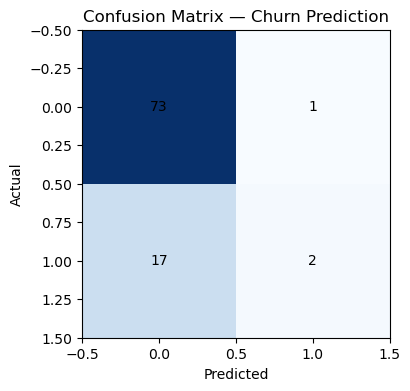

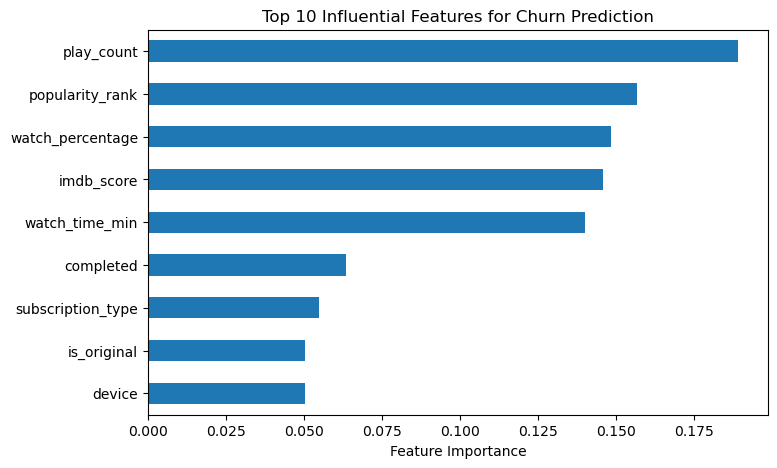

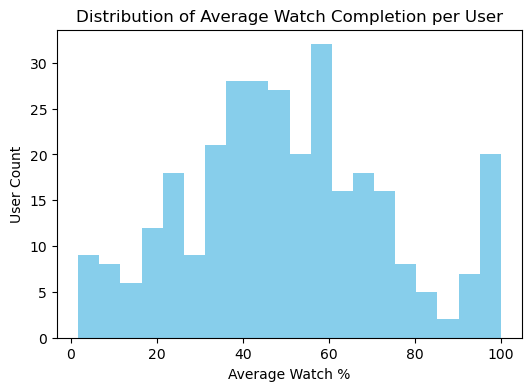

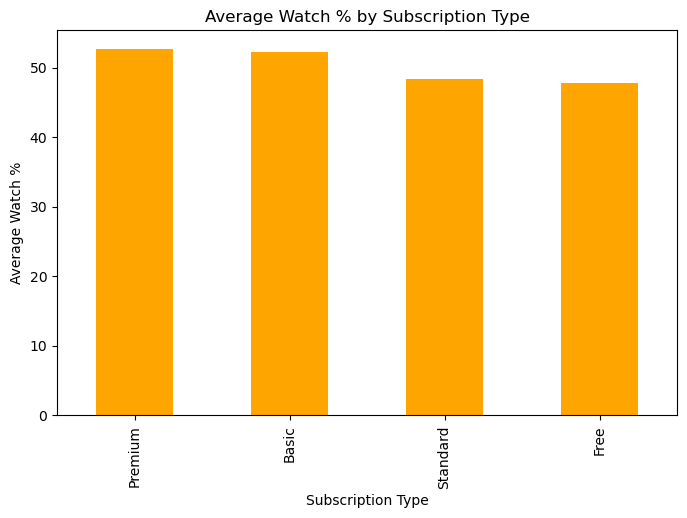


⚠️  Potentially churning users identified: 49


,user_id,subscription_type,device,watch_percentage,completed,predicted_churn
14,user_0018,0,1,100.000000,1.000000,1
19,user_0023,2,3,19.175000,0.000000,1
25,user_0034,0,0,36.550000,0.000000,1
29,user_0039,0,2,36.944444,0.222222,1
31,user_0042,1,0,31.580000,0.200000,1
40,user_0052,0,0,31.933333,0.000000,1
47,user_0063,2,1,56.450000,0.333333,1
54,user_0076,0,3,52.833333,0.000000,1
76,user_0103,2,1,44.850000,0.250000,1
95,user_0126,3,2,41.842857,0.000000,1


In [53]:
# --- Use Case 4: User Engagement & Churn Prediction ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Copy dataset
df_churn = df.copy()

# --- Step 1: Aggregate to user-level engagement ---
user_engagement = df_churn.groupby('user_id').agg({
    'watch_time_min': 'mean',
    'watch_percentage': 'mean',
    'completed': 'mean',
    'play_count': 'sum',
    'is_original': 'mean',
    'imdb_score': 'mean',
    'popularity_rank': 'mean',
    'churn_label': 'max',      # label to predict
    'subscription_type': lambda x: x.mode()[0],
    'device': lambda x: x.mode()[0]
}).reset_index()

# Encode categorical columns
user_engagement['subscription_type'] = user_engagement['subscription_type'].astype('category').cat.codes
user_engagement['device'] = user_engagement['device'].astype('category').cat.codes

# --- Step 2: Define features and label ---
X = user_engagement.drop(columns=['user_id', 'churn_label'])
y = user_engagement['churn_label']

# --- Step 3: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Step 4: Model Training ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- Step 5: Evaluation ---
y_pred = rf.predict(X_test)
print("\n📋 Classification Report (Churn Prediction):")
print(classification_report(y_test, y_pred))

# --- Step 6: Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix — Churn Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

# --- Step 7: Feature Importance Visualization ---
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Influential Features for Churn Prediction")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.show()

# --- Step 8: Engagement Segment Visualization ---
plt.figure(figsize=(6,4))
plt.hist(user_engagement['watch_percentage'], bins=20, color='skyblue')
plt.title("Distribution of Average Watch Completion per User")
plt.xlabel("Average Watch %")
plt.ylabel("User Count")
plt.show()

# --- Step 9: Insight on Subscription Types ---
avg_watch_by_sub = df_churn.groupby('subscription_type')['watch_percentage'].mean().sort_values(ascending=False)
avg_watch_by_sub.plot(kind='bar', color='orange')
plt.title("Average Watch % by Subscription Type")
plt.xlabel("Subscription Type")
plt.ylabel("Average Watch %")
plt.show()

# --- Step 10: Example: List of Potentially Churning Users ---
user_engagement['predicted_churn'] = rf.predict(X)
potential_churners = user_engagement[user_engagement['predicted_churn']==1]
print(f"\n⚠️  Potentially churning users identified: {len(potential_churners)}")
display(potential_churners[['user_id','subscription_type','device','watch_percentage','completed','predicted_churn']].head(10))


In [37]:
# Use Case 5 Sentiment Analysis on OTT Content

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


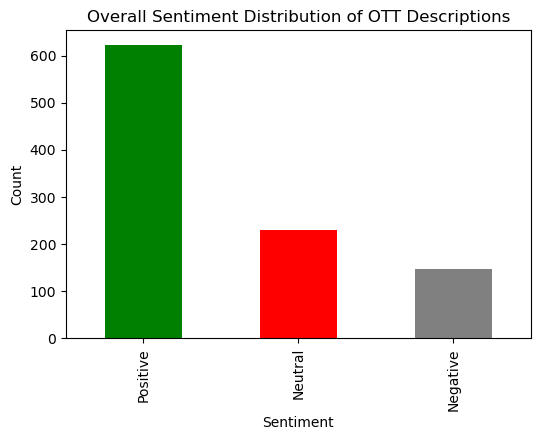

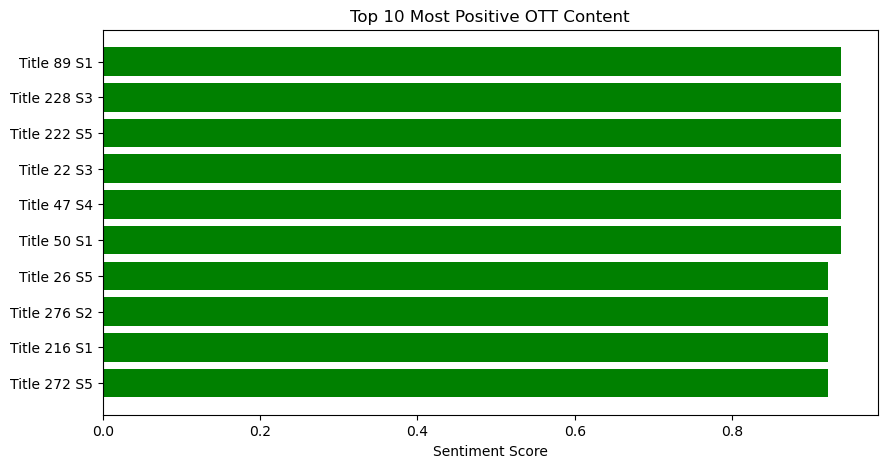

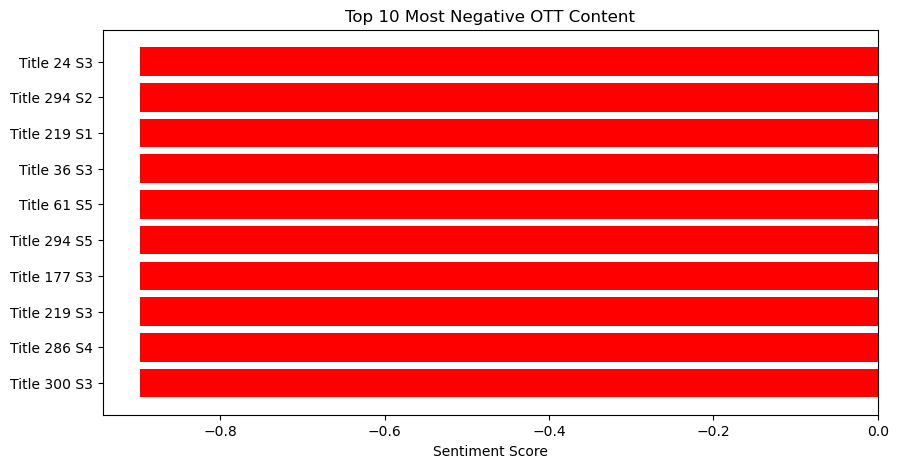


Recommended uplifting content in 'Drama' genre based on positive sentiment:


,title,primary_genre,sentiment_score,sentiment_label
101,Title 132 S5,Drama,0.8074,Positive
111,Title 19 S3,Drama,0.8074,Positive
155,Title 243 S4,Drama,0.8074,Positive
851,Title 115 S4,Drama,0.8074,Positive
483,Title 173 S2,Drama,0.8074,Positive


In [51]:
# --- Use Case 5: Sentiment Analysis on Content Descriptions ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if not already
nltk.download('vader_lexicon')

# Load dataset
df_sent = df.copy()

# Combine relevant text fields to form a pseudo "review" column
df_sent['text_for_sentiment'] = (
    df_sent['description'].astype(str) + " " +
    df_sent['mood_tag'].astype(str) + " " +
    df_sent['primary_genre'].astype(str)
)

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Compute sentiment polarity scores
df_sent['sentiment_score'] = df_sent['text_for_sentiment'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment category
def sentiment_category(score):
    if score >= 0.2:
        return 'Positive'
    elif score <= -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df_sent['sentiment_label'] = df_sent['sentiment_score'].apply(sentiment_category)

# ✅ Visualization 1: Sentiment distribution
plt.figure(figsize=(6,4))
df_sent['sentiment_label'].value_counts().plot(kind='bar', color=['green','red','gray'])
plt.title('Overall Sentiment Distribution of OTT Descriptions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# ✅ Visualization 2: Top 10 most positive content
top_positive = df_sent.sort_values('sentiment_score', ascending=False).head(10)
plt.figure(figsize=(10,5))
plt.barh(top_positive['title'], top_positive['sentiment_score'], color='green')
plt.title('Top 10 Most Positive OTT Content')
plt.xlabel('Sentiment Score')
plt.gca().invert_yaxis()
plt.show()

# ✅ Visualization 3: Top 10 most negative content
top_negative = df_sent.sort_values('sentiment_score', ascending=True).head(10)
plt.figure(figsize=(10,5))
plt.barh(top_negative['title'], top_negative['sentiment_score'], color='red')
plt.title('Top 10 Most Negative OTT Content')
plt.xlabel('Sentiment Score')
plt.gca().invert_yaxis()
plt.show()

# ✅ Example recommendation based on positive sentiment & genre preference
def sentiment_based_recommend(preferred_genre='Drama', top_n=5):
    genre_df = df_sent[df_sent['primary_genre'] == preferred_genre]
    pos_df = genre_df[genre_df['sentiment_label'] == 'Positive']
    top = pos_df.sort_values('sentiment_score', ascending=False).head(top_n)
    return top[['title', 'primary_genre', 'sentiment_score', 'sentiment_label']]

# Demo
print("\nRecommended uplifting content in 'Drama' genre based on positive sentiment:")
display(sentiment_based_recommend('Drama', top_n=5))
